In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import models, layers, regularizers
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras import backend as K

In [25]:
# Set some parameters
im_width = 256
im_height = 256
border = 5

In [ ]:
# Set some parameters
im_width = 224
im_height = 224
border = 5

In [26]:
ids = next(os.walk("/content/drive/My Drive/lr_images/"))[2]
print("No. of images = ", len(ids))

No. of images =  612


In [27]:
X = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)
y = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)

In [ ]:
# tqdm is used to display the progress bar
for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
    # Load images
    img = load_img("/content/drive/My Drive/images/"+id_, grayscale=True)
    x_img = img_to_array(img)
    x_img = resize(x_img, (256, 256, 1), mode = 'constant', preserve_range = True)
    # Load masks
    mask = img_to_array(load_img("/content/drive/My Drive/masks/"+id_, grayscale=True))
    mask = resize(mask, (256, 256, 1), mode = 'constant', preserve_range = True)
    # Save images
    X[n] = x_img/255.0
    y[n] = mask/255.0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/612 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [29]:
# tqdm is used to display the progress bar
for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
    # Load images
    img = load_img("/content/drive/My Drive/lr_images/"+id_, grayscale=True)
    x_img = img_to_array(img)
    x_img = resize(x_img, (256, 256, 1), mode = 'constant', preserve_range = True)
    # Load masks
    mask = img_to_array(load_img("/content/drive/My Drive/lr_masks/"+id_, grayscale=True))
    mask = resize(mask, (256, 256, 1), mode = 'constant', preserve_range = True)
    # Save images
    X[n] = x_img/255.0
    y[n] = mask/255.0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/612 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [30]:
# Split train and valid
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=0)

In [31]:
len(y_valid)

62

In [32]:
X_valid

array([[[[0.04312641],
         [0.04313726],
         [0.04313726],
         ...,
         [0.04313726],
         [0.04313726],
         [0.04312641]],

        [[0.04312641],
         [0.04313726],
         [0.04313726],
         ...,
         [0.04313726],
         [0.04313726],
         [0.04312641]],

        [[0.04312641],
         [0.04313726],
         [0.04313726],
         ...,
         [0.04313726],
         [0.04313726],
         [0.04312641]],

        ...,

        [[0.04410384],
         [0.03529806],
         [0.04411305],
         ...,
         [0.03529412],
         [0.03529412],
         [0.03528524]],

        [[0.04410384],
         [0.03529806],
         [0.04411305],
         ...,
         [0.03529412],
         [0.03529412],
         [0.03528524]],

        [[0.04410384],
         [0.03529806],
         [0.04411305],
         ...,
         [0.03529412],
         [0.03529412],
         [0.03528524]]],


       [[[0.04312641],
         [0.04313726],
         [0.04

Text(0.5, 1.0, 'Mask')

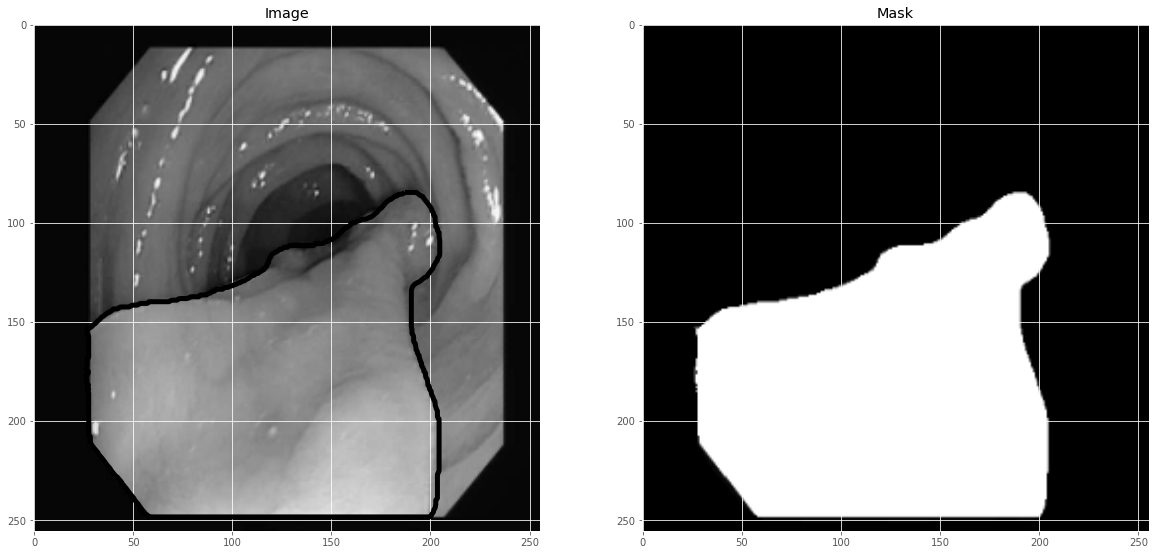

In [ ]:
# Visualize any randome image along with the mask
ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0 # salt indicator

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 15))

ax1.imshow(X_train[ix, ..., 0], cmap = 'gray', interpolation = 'bilinear')
if has_mask: # if salt
    # draw a boundary(contour) in the original image separating salt and non-salt areas
    ax1.contour(y_train[ix].squeeze(), colors = 'k', linewidths = 5, levels = [0.5])
ax1.set_title('Image')

ax2.imshow(y_train[ix].squeeze(), cmap = 'gray', interpolation = 'bilinear')
ax2.set_title('Mask')

Text(0.5, 1.0, 'Mask')

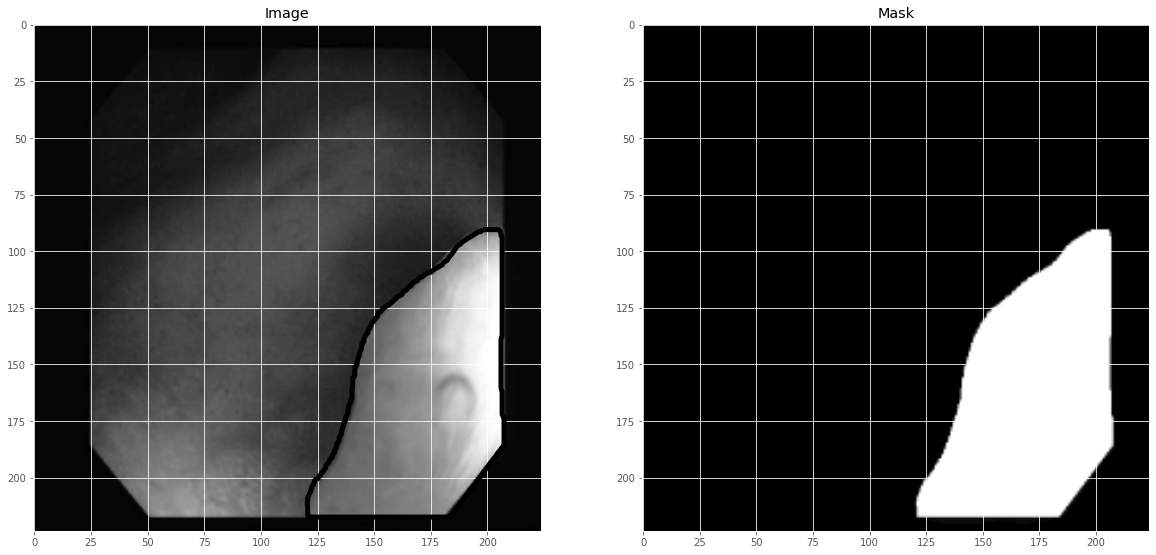

In [ ]:
# Visualize any randome image along with the mask
ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0 # salt indicator

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 15))

ax1.imshow(X_train[ix, ..., 0], cmap = 'gray', interpolation = 'bilinear')
if has_mask: # if salt
    # draw a boundary(contour) in the original image separating salt and non-salt areas
    ax1.contour(y_train[ix].squeeze(), colors = 'k', linewidths = 5, levels = [0.5])
ax1.set_title('Image')

ax2.imshow(y_train[ix].squeeze(), cmap = 'gray', interpolation = 'bilinear')
ax2.set_title('Mask')

In [33]:
def conv_block(x, filter_size, size, dropout, batch_norm=False):
    
    conv = layers.Conv2D(size, (filter_size, filter_size), padding="same")(x)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)

    conv = layers.Conv2D(size, (filter_size, filter_size), padding="same")(conv)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)
    
    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)

    return conv

In [34]:
def repeat_elem(tensor, rep):
     return layers.Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3),
                          arguments={'repnum': rep})(tensor)

In [35]:
def res_conv_block(x, filter_size, size, dropout, batch_norm=False):
    conv = layers.Conv2D(size, (filter_size, filter_size), padding='same')(x)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation('relu')(conv)
    
    conv = layers.Conv2D(size, (filter_size, filter_size), padding='same')(conv)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    #conv = layers.Activation('relu')(conv)    #Activation before addition with shortcut
    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)

    shortcut = layers.Conv2D(size, kernel_size=(1, 1), padding='same')(x)
    if batch_norm is True:
        shortcut = layers.BatchNormalization(axis=3)(shortcut)

    res_path = layers.add([shortcut, conv])
    res_path = layers.Activation('relu')(res_path)    #Activation after addition with shortcut (Original residual block)
    return res_path

In [36]:
def gating_signal(input, out_size, batch_norm=False):
    x = layers.Conv2D(out_size, (1, 1), padding='same')(input)
    if batch_norm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x

In [37]:
def attention_block(x, gating, inter_shape):
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)

# Getting the x signal to the same shape as the gating signal
    theta_x = layers.Conv2D(inter_shape, (2, 2), strides=(2, 2), padding='same')(x)  # 16
    shape_theta_x = K.int_shape(theta_x)

# Getting the gating signal to the same number of filters as the inter_shape
    phi_g = layers.Conv2D(inter_shape, (1, 1), padding='same')(gating)
    upsample_g = layers.Conv2DTranspose(inter_shape, (3, 3),
                                 strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]),
                                 padding='same')(phi_g)  # 16

    concat_xg = layers.add([upsample_g, theta_x])
    act_xg = layers.Activation('relu')(concat_xg)
    psi = layers.Conv2D(1, (1, 1), padding='same')(act_xg)
    sigmoid_xg = layers.Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)
    upsample_psi = layers.UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)  # 32

    upsample_psi = repeat_elem(upsample_psi, shape_x[3])

    y = layers.multiply([upsample_psi, x])

    result = layers.Conv2D(shape_x[3], (1, 1), padding='same')(y)
    result_bn = layers.BatchNormalization()(result)
    return result_bn

In [38]:
def Attention_ResUNet(input_shape, NUM_CLASSES=1, dropout_rate=0.0, batch_norm=True):
    '''
    Rsidual UNet, with attention 
    
    '''
    # network structure
    FILTER_NUM = 64 # number of basic filters for the first layer
    FILTER_SIZE = 3 # size of the convolutional filter
    UP_SAMP_SIZE = 2 # size of upsampling filters
    # input data
    # dimension of the image depth
    inputs = layers.Input(input_shape, dtype=tf.float32)
    axis = 3

    # Downsampling layers
    # DownRes 1, double residual convolution + pooling
    conv_128 = res_conv_block(inputs, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    pool_64 = layers.MaxPooling2D(pool_size=(2,2))(conv_128)
    # DownRes 2
    conv_64 = res_conv_block(pool_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    pool_32 = layers.MaxPooling2D(pool_size=(2,2))(conv_64)
    # DownRes 3
    conv_32 = res_conv_block(pool_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    pool_16 = layers.MaxPooling2D(pool_size=(2,2))(conv_32)
    # DownRes 4
    conv_16 = res_conv_block(pool_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    pool_8 = layers.MaxPooling2D(pool_size=(2,2))(conv_16)
    # DownRes 5, convolution only
    conv_8 = res_conv_block(pool_8, FILTER_SIZE, 16*FILTER_NUM, dropout_rate, batch_norm)

    # Upsampling layers
    # UpRes 6, attention gated concatenation + upsampling + double residual convolution
    gating_16 = gating_signal(conv_8, 8*FILTER_NUM, batch_norm)
    att_16 = attention_block(conv_16, gating_16, 8*FILTER_NUM)
    up_16 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_8)
    up_16 = layers.concatenate([up_16, att_16], axis=axis)
    up_conv_16 = res_conv_block(up_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 7
    gating_32 = gating_signal(up_conv_16, 4*FILTER_NUM, batch_norm)
    att_32 = attention_block(conv_32, gating_32, 4*FILTER_NUM)
    up_32 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_16)
    up_32 = layers.concatenate([up_32, att_32], axis=axis)
    up_conv_32 = res_conv_block(up_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 8
    gating_64 = gating_signal(up_conv_32, 2*FILTER_NUM, batch_norm)
    att_64 = attention_block(conv_64, gating_64, 2*FILTER_NUM)
    up_64 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32)
    up_64 = layers.concatenate([up_64, att_64], axis=axis)
    up_conv_64 = res_conv_block(up_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 9
    gating_128 = gating_signal(up_conv_64, FILTER_NUM, batch_norm)
    att_128 = attention_block(conv_128, gating_128, FILTER_NUM)
    up_128 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64)
    up_128 = layers.concatenate([up_128, att_128], axis=axis)
    up_conv_128 = res_conv_block(up_128, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)

    # 1*1 convolutional layers
    
    conv_final = layers.Conv2D(NUM_CLASSES, kernel_size=(1,1))(up_conv_128)
    conv_final = layers.BatchNormalization(axis=axis)(conv_final)
    conv_final = layers.Activation('sigmoid')(conv_final)  #Change to softmax for multichannel

    # Model integration
    model = models.Model(inputs, conv_final, name="AttentionResUNet")
    return model

In [39]:
input_shape = (256, 256, 1)
Attention_ResUNet(input_shape, NUM_CLASSES=1, dropout_rate=0.0, batch_norm=True)

In [ ]:
input_img = (224, 224, 1)
Attention_ResUNet(input_img, NUM_CLASSES=1, dropout_rate=0.0, batch_norm=True)

In [40]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]
num_labels = 1  #Binary
input_img = (IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS)

In [41]:
model = Attention_ResUNet(input_img)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
model.summary()

Model: "AttentionResUNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_48 (Conv2D)             (None, 256, 256, 64  640         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_36 (BatchN  (None, 256, 256, 64  256        ['conv2d_48[0][0]']              
 ormalization)                  )                                                  

In [ ]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('/content/drive/My Drive/Colab Notebooks/RESUNET.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [ ]:
results = model.fit(X_train, y_train, batch_size=8, epochs=100, callbacks=callbacks,\
                    validation_data=(X_valid, y_valid))

Epoch 1/100
69/69 [==============================] - ETA: 0s - loss: 0.6663 - accuracy: 0.7348
Epoch 1: val_loss improved from inf to 123.47723, saving model to /content/drive/My Drive/Colab Notebooks/RESUNET.h5
69/69 [==============================] - 489s 7s/step - loss: 0.6663 - accuracy: 0.7348 - val_loss: 123.4772 - val_accuracy: 0.1013 - lr: 0.0010
Epoch 2/100
69/69 [==============================] - ETA: 0s - loss: 0.6114 - accuracy: 0.8139
Epoch 2: val_loss improved from 123.47723 to 6.41127, saving model to /content/drive/My Drive/Colab Notebooks/RESUNET.h5
69/69 [==============================] - 485s 7s/step - loss: 0.6114 - accuracy: 0.8139 - val_loss: 6.4113 - val_accuracy: 0.1013 - lr: 0.0010
Epoch 3/100
69/69 [==============================] - ETA: 0s - loss: 0.5786 - accuracy: 0.8490
Epoch 3: val_loss improved from 6.41127 to 0.64750, saving model to /content/drive/My Drive/Colab Notebooks/RESUNET.h5
69/69 [==============================] - 482s 7s/step - loss: 0.5786 -

In [ ]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

In [42]:
# load the best model
model.load_weights('/content/drive/My Drive/Colab Notebooks/RESUNET.h5')

In [43]:
# Evaluate on validation set (this must be equals to the best log_loss)
model.evaluate(X_valid, y_valid, verbose=1)

2/2 [==============================] - 13s 6s/step - loss: 0.1824 - accuracy: 0.9872


[0.1824098378419876, 0.9871730208396912]

In [ ]:
# Evaluate on validation set (this must be equals to the best log_loss)
model.evaluate(X_valid, y_valid, verbose=1)

2/2 [==============================] - 12s 5s/step - loss: 0.1923 - accuracy: 0.9859


[0.19229061901569366, 0.9858580827713013]

In [44]:
# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)

2/2 [==============================] - 11s 5s/step


In [ ]:
# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)

2/2 [==============================] - 11s 5s/step


In [45]:
# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

In [46]:
# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

In [70]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    """Function to plot the results"""
    # if ix is None:
    #     ix = random.randint(0, len(X))
    ix=1

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='gray')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Image')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Ground Truth')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Ground Truth Predicted')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Ground Truth Predicted binary');

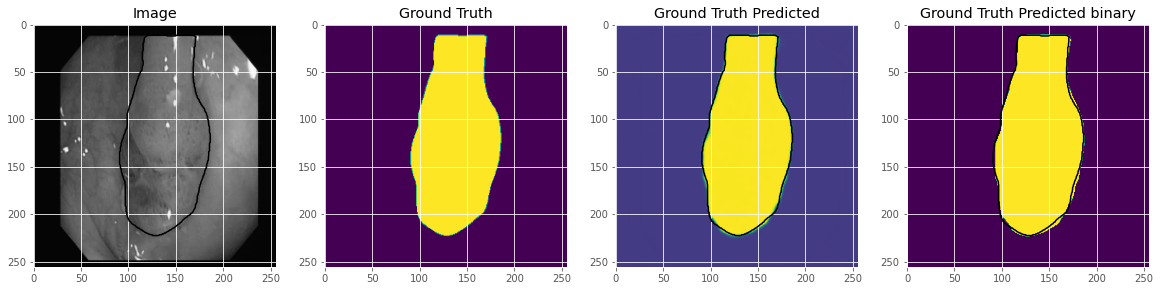

In [71]:
# Check if training data looks all right
plot_sample(X_train, y_train, preds_train, preds_train_t)

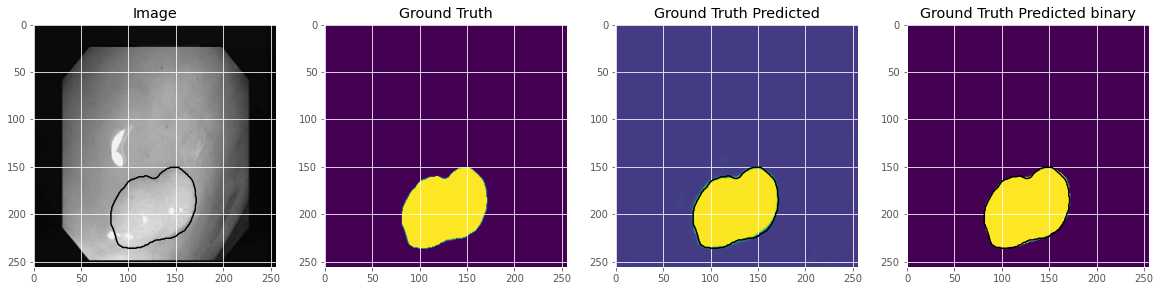

In [60]:
# Check if training data looks all right
plot_sample(X_train, y_train, preds_train, preds_train_t)

In [49]:
import pandas as pd
n_classes = 2
from tensorflow.keras.metrics import MeanIoU
IoU_values = []
for img in range(0, X_valid.shape[0]):
    temp_img = X_valid[img]
    ground_truth=y_valid[img]
    temp_img_input=np.expand_dims(temp_img, 0)
    prediction = (model.predict(temp_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
    
    IoU = MeanIoU(num_classes=n_classes)
    IoU.update_state(ground_truth[:,:,0], prediction)
    IoU = IoU.result().numpy()
    IoU_values.append(IoU)

    print(IoU)

0.95918524
0.956189
0.81336164
0.9484167
0.9673039
0.97002065
0.9317546
0.91865176
0.94445276
0.96352786
0.9720739
0.9519934
0.97100055
0.97198653
0.9746164
0.96906865
0.97446346
0.9606997
0.95827323
0.94924504
0.9643214
0.9518001
0.97263604
0.9654578
0.97106254
0.9640727
0.97032386
0.9726258
0.9701773
0.48499298
0.9545525
0.90560734
0.9433186
0.95162356
0.9532665
0.98111665
0.98408604
0.925195
0.97324353
0.95218396
0.958139
0.9657311
0.9481827
0.9411645
0.9539256
0.9401946
0.9499982
0.9579952
0.96768093
0.9767289
0.9709032
0.95774794
0.97341996
0.90807956
0.9650152
0.9720478
0.9552018
0.94444835
0.94863033
0.9372493
0.9794683
0.94835454


In [ ]:
import pandas as pd
n_classes = 2
from tensorflow.keras.metrics import MeanIoU
IoU_values = []
for img in range(0, X_valid.shape[0]):
    temp_img = X_valid[img]
    ground_truth=y_valid[img]
    temp_img_input=np.expand_dims(temp_img, 0)
    prediction = (model.predict(temp_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
    
    IoU = MeanIoU(num_classes=n_classes)
    IoU.update_state(ground_truth[:,:,0], prediction)
    IoU = IoU.result().numpy()
    IoU_values.append(IoU)

    print(IoU)

0.9113985
0.944432
0.92774856
0.95949644
0.91167784
0.90560734
0.94911623
0.9484812
0.9534894
0.9693711
0.9563698
0.9657366
0.47608948
0.96547484
0.97102207
0.97490585
0.9488531
0.97242415
0.8978927
0.9477064
0.94409347
0.83472395
0.97799295
0.9395244
0.95910144
0.9645768
0.9394462
0.9356583
0.95451117
0.94472677
0.9016918
0.93235743
0.91865176
0.9555212
0.94256645
0.95220995
0.9680569
0.94003373
0.97231567
0.9467373
0.8063463
0.9584433
0.97412777
0.94313896
0.958935
0.9461159
0.92937857
0.93295825
0.96757257
0.9615401
0.94835454
0.9098188
0.782081
0.94820285
0.96864474
0.9562974
0.9733598
0.95762336
0.9693587
0.94353056
0.96859974
0.9660177


In [ ]:
df = pd.DataFrame(IoU_values, columns=["IoU"])
df = df[df.IoU != 1.0]    
mean_IoU = df.mean().values
print("Mean IoU is: ", mean_IoU)

Mean IoU is:  [0.88921815]


In [53]:
df = pd.DataFrame(IoU_values, columns=["IoU"])
df = df[df.IoU != 1.0]    
mean_IoU = df.mean().values
print("Mean IoU is: ", mean_IoU)

Mean IoU is:  [0.95771366]
